# Create a GeoZarr with multi-scales containing the WebMercatorQuad TMS

## Load example dataset from NetCDF into Xarray

In [1]:
import cf_xarray  # noqa
import morecantile
import pyproj
import rioxarray  # noqa
import xarray as xr
from matplotlib import pyplot as plt
from rasterio.rio.overview import get_maximum_overview_level

# For zarr_format=2 encoding
from rio_tiler.io.xarray import XarrayReader

In [2]:
fp_base = "20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1"
input = f"../data/{fp_base}.nc"
v2_output = f"../output/v2/{fp_base}_custom_multiscales.zarr"

In [3]:
ds = xr.open_dataset(input)

## Check that all variables have a CF-compliant standard name


In [4]:
standard_names = ds.cf.standard_names
vars_with_standard_names = [v[0] for v in ds.cf.standard_names.values()]
compliant_vars = []
non_complaint_vars = []
for var in ds.variables:
    if var not in vars_with_standard_names:
        non_complaint_vars.append(var)
    else:
        compliant_vars.append(var)
        assert ds[var].attrs["standard_name"]

print(f"These variables do NOT have a CF-compliant standard name: {non_complaint_vars}")
print(f"These variables have a CF-compliant standard name: {compliant_vars}")

These variables do NOT have a CF-compliant standard name: ['analysis_error', 'mask']
These variables have a CF-compliant standard name: ['time', 'lat', 'lon', 'analysed_sst', 'sea_ice_fraction']


Not all the variables in this dataset have a CF-compliant standard name. See https://github.com/zarr-developers/geozarr-spec/issues/60 for a recommendation that CF-compliant standard names should be a "SHOULD" rather than a "MUST" condition in the GeoZarr spec. For now, let's subset to the variables that do use CF-compliant standard names.

In [5]:
ds = ds[compliant_vars]

## Assign CRS information to an auxiliary variable using rioxarray

In [6]:
ds = ds.rio.write_crs("epsg:4326")
# Specify which variable contains CRS information using grid_mapping
for var in ds.data_vars:
    ds[var].attrs["grid_mapping"] = "spatial_ref"

## Define a custom TMS

crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
bounds: (-179.99500549324037, -89.99499786365084, 180.0050000000763, 89.99499786365084)


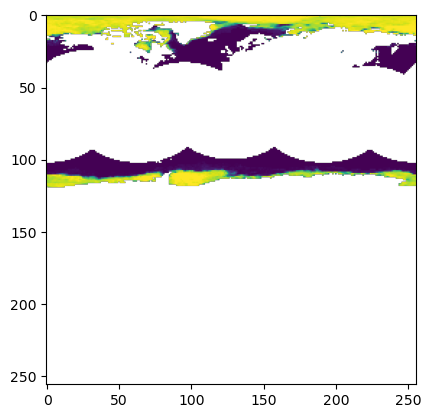

In [7]:
x_chunk_size = 512
y_chunk_size = 512

with XarrayReader(ds[var]) as dst_wmq:
    pyproj_crs = pyproj.CRS.from_wkt(dst_wmq.crs.to_wkt())
    print(f"crs: {pyproj_crs}")
    bounds = dst_wmq.bounds
    print(f"bounds: {bounds}")

    maxzoom = get_maximum_overview_level(
        ds[var].shape[2], ds[var].shape[1], minsize=min(x_chunk_size, y_chunk_size)
    )

    custom_tms = morecantile.TileMatrixSet.custom(
        extent=bounds,
        crs=pyproj_crs,
        tile_width=x_chunk_size,
        tile_height=y_chunk_size,
        minzoom=0,
        maxzoom=maxzoom,
        matrix_scale=[1, 1],
        decimation_base=2,
    )

with XarrayReader(ds[var], tms=custom_tms) as dst:
    tile = dst.tile(0, 0, 0).data

plt.imshow(tile.squeeze())